## Analyzing and cleaning the dataset

In [1]:
import pandas as pd

In [2]:
file_path = "fake_reviews.csv"
dataset = pd.read_csv(file_path)

In [3]:
data_info = dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  40432 non-null  object
 1   rating    40432 non-null  int64 
 2   label     40432 non-null  object
 3   text_     40432 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [4]:
dataset_head = dataset.head()
print(dataset_head)

             category  rating label  \
0  Home_and_Kitchen_5       5    CG   
1  Home_and_Kitchen_5       5    CG   
2  Home_and_Kitchen_5       5    CG   
3  Home_and_Kitchen_5       1    CG   
4  Home_and_Kitchen_5       5    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  


In [5]:
# Check for missing values
missing_values = dataset.isnull().sum()
print(missing_values)

category    0
rating      0
label       0
text_       0
dtype: int64


In [6]:
# Check for duplicate entries
duplicate_entries = dataset.duplicated().sum()
print(duplicate_entries)

12


In [7]:
# Making a copy of the original dataset
dataset_cleaned = dataset.copy(deep=True)

In [8]:
# Remove duplicate rows from the dataset
dataset_cleaned = dataset.drop_duplicates()

# Verify if duplicates were removed
remaining_duplicates = dataset_cleaned.duplicated().sum()
print("Remaining duplicates:", remaining_duplicates)

Remaining duplicates: 0


In [9]:
label_distribution = dataset['label'].value_counts()
print(label_distribution)

label
CG    20216
OR    20216
Name: count, dtype: int64


In [10]:
# Label distribution
label_distribution = dataset_cleaned['label'].value_counts()
print(label_distribution)

label
OR    20215
CG    20205
Name: count, dtype: int64


In [11]:
# Rating distribution
rating_distribution = dataset_cleaned['rating'].value_counts()
print(rating_distribution)

rating
5    24547
4     7965
3     3786
1     2155
2     1967
Name: count, dtype: int64


In [12]:
dataset.shape

(40432, 4)

In [13]:
dataset_cleaned.shape

(40420, 4)

In [14]:
# Calculate average text length for fake (CG) and real (OR) reviews
dataset_cleaned.loc[:, 'text_length'] = dataset_cleaned['text_'].apply(len)
avg_text_length = dataset_cleaned.groupby('label')['text_length'].mean()
print(avg_text_length)

label
CG    307.750953
OR    396.995449
Name: text_length, dtype: float64


C:\Users\91911\AppData\Local\Temp\ipykernel_28180\1706902404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned.loc[:, 'text_length'] = dataset_cleaned['text_'].apply(len)


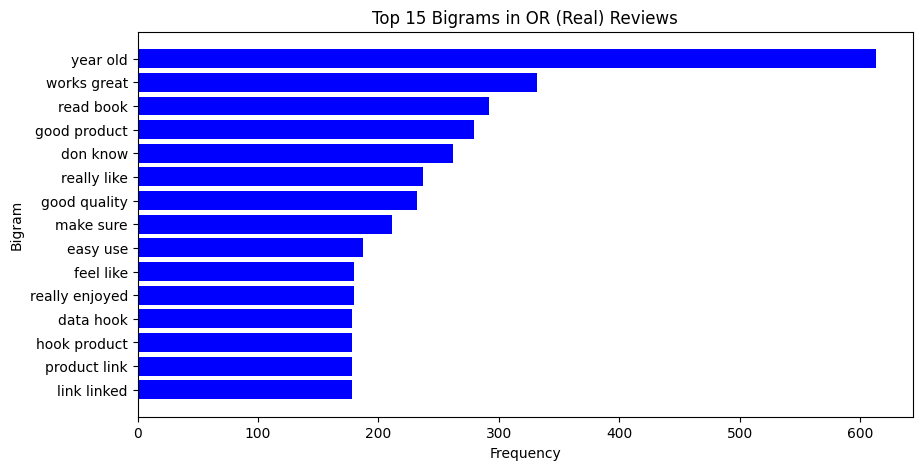

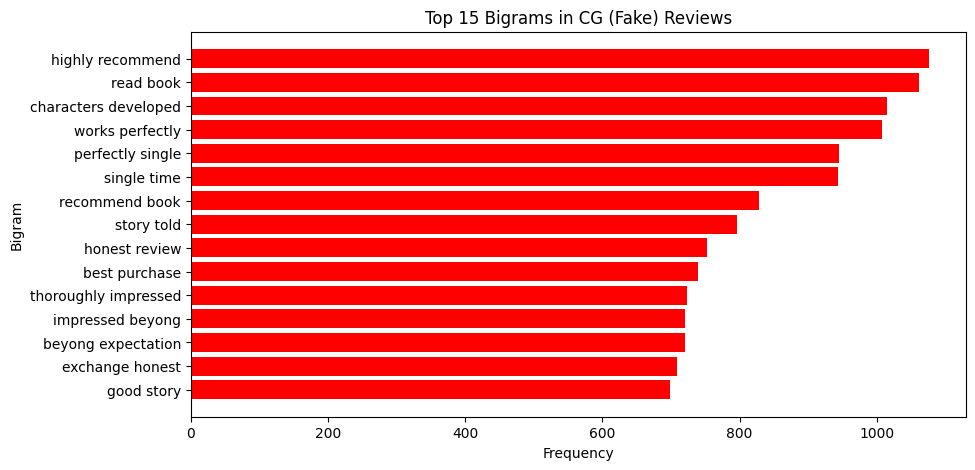

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    """Generate and return the top n bigrams or trigrams in the corpus."""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Separate OR and CG reviews
corpus_OR = dataset_cleaned[dataset_cleaned['label'] == 'OR']['text_']
corpus_CG = dataset_cleaned[dataset_cleaned['label'] == 'CG']['text_']

# Get top 15 bigrams for each label
top_15_bigrams_OR = get_top_ngrams(corpus_OR, ngram_range=(2, 2), n=15)
top_15_bigrams_CG = get_top_ngrams(corpus_CG, ngram_range=(2, 2), n=15)

# Convert to DataFrame for easier plotting
df_bigrams_OR = pd.DataFrame(top_15_bigrams_OR, columns=['Bigram', 'Frequency'])
df_bigrams_CG = pd.DataFrame(top_15_bigrams_CG, columns=['Bigram', 'Frequency'])

# Plot for OR reviews
plt.figure(figsize=(10, 5))
plt.barh(df_bigrams_OR['Bigram'], df_bigrams_OR['Frequency'], color='blue')
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.title("Top 15 Bigrams in OR (Real) Reviews")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Plot for CG reviews
plt.figure(figsize=(10, 5))
plt.barh(df_bigrams_CG['Bigram'], df_bigrams_CG['Frequency'], color='red')
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.title("Top 15 Bigrams in CG (Fake) Reviews")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [16]:
import string
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

In [17]:
# Download stopwords and wordnet for lemmatization (run only once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91911\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91911\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Initialize objects for stemming and lemmatizing
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [19]:
# Define a function to clean each review
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Transform to lowercase
    text = text.lower()
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Tokenize text (split into words) and remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    
    # Apply stemming and lemmatizing
    words = [stemmer.stem(word) for word in words]  # Stemming
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatizing
    
    # Join words back to a single string
    return ' '.join(words)

# Apply preprocessing to the 'text_' column in your dataset
dataset_cleaned.loc[:, 'processed_text'] = dataset_cleaned['text_'].apply(preprocess_text)

C:\Users\91911\AppData\Local\Temp\ipykernel_28180\1308589912.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned.loc[:, 'processed_text'] = dataset_cleaned['text_'].apply(preprocess_text)


In [20]:
!pip install textblob
!pip install vaderSentiment

In [21]:
from textblob import TextBlob

# Function to calculate polarity and subjectivity
def analyze_sentiment_textblob(text):
    blob = TextBlob(text)
    return blob.polarity, blob.subjectivity

# Apply to the dataset
dataset_cleaned['polarity'], dataset_cleaned['subjectivity'] = zip(*dataset_cleaned['processed_text'].apply(analyze_sentiment_textblob))

# View the updated dataset
print(dataset_cleaned[['processed_text', 'polarity', 'subjectivity']].head())

                                     processed_text  polarity  subjectivity
0  love well made sturdi comfort love itveri pretti      0.50         0.600
1      love great upgrad origin ive mine coupl year      0.65         0.675
2            pillow save back love look feel pillow      0.25         0.300
3           miss inform use best purchas ever price      1.00         0.300
4               nice set good qualiti set two month      0.65         0.800


C:\Users\91911\AppData\Local\Temp\ipykernel_28180\2045394765.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['polarity'], dataset_cleaned['subjectivity'] = zip(*dataset_cleaned['processed_text'].apply(analyze_sentiment_textblob))
C:\Users\91911\AppData\Local\Temp\ipykernel_28180\2045394765.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['polarity'], dataset_cleaned['subjectivity'] = zip(*dataset_cleaned['processed_text'].apply(analyze_sentiment_textblob))


In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to calculate VADER sentiment scores
def analyze_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

# Apply to the dataset
dataset_cleaned[['neg', 'neu', 'pos', 'compound']] = dataset_cleaned['processed_text'].apply(
    lambda x: pd.Series(analyze_sentiment_vader(x))
)

# View the updated dataset
print(dataset_cleaned[['processed_text', 'neg', 'neu', 'pos', 'compound']].head())

                                     processed_text    neg    neu    pos  \
0  love well made sturdi comfort love itveri pretti  0.000  0.235  0.765   
1      love great upgrad origin ive mine coupl year  0.000  0.420  0.580   
2            pillow save back love look feel pillow  0.000  0.403  0.597   
3           miss inform use best purchas ever price  0.148  0.463  0.389   
4               nice set good qualiti set two month  0.000  0.467  0.533   

   compound  
0    0.9186  
1    0.8519  
2    0.8126  
3    0.5574  
4    0.6908  


C:\Users\91911\AppData\Local\Temp\ipykernel_28180\3477214716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned[['neg', 'neu', 'pos', 'compound']] = dataset_cleaned['processed_text'].apply(
C:\Users\91911\AppData\Local\Temp\ipykernel_28180\3477214716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned[['neg', 'neu', 'pos', 'compound']] = dataset_cleaned['processed_text'].apply(
C:\Users\91911\AppData\Local\Temp\ipykernel_28180\3477214716.py:12: SettingWithCopyWarning: 
A v

In [23]:
# Group by label and calculate mean polarity, subjectivity, and compound
avg_sentiments = dataset_cleaned.groupby('label')[['polarity', 'subjectivity', 'compound']].mean()

# Print the results
print(avg_sentiments)

       polarity  subjectivity  compound
label                                  
CG     0.305308      0.495861  0.621884
OR     0.250830      0.481261  0.561539


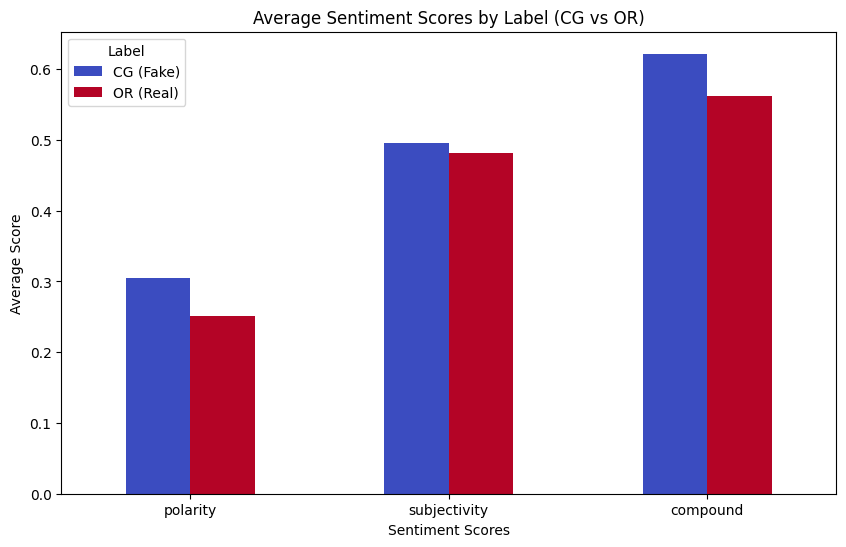

In [24]:
import matplotlib.pyplot as plt

# Transpose for easier plotting
avg_sentiments.T.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')

plt.title('Average Sentiment Scores by Label (CG vs OR)')
plt.ylabel('Average Score')
plt.xlabel('Sentiment Scores')
plt.xticks(rotation=0)
plt.legend(title='Label', labels=['CG (Fake)', 'OR (Real)'])
plt.show()

In [25]:
dataset_cleaned.to_csv('cleaned_fake_reviews.csv', index=False)

## Training and Testing ML models

In [26]:
# Load your cleaned dataset (replace the path if necessary)
df_cleaned = pd.read_csv('cleaned_fake_reviews.csv')

# Define your features (X) and target (y)
X = df_cleaned[['processed_text', 'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']]  # Features
y = df_cleaned['label']  # Target variable (CG/OR)

# Perform train-test split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shape of your split data
print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")

Training data: (32336, 7), Test data: (8084, 7)


In [27]:
print(df_cleaned.columns)

Index(['category', 'rating', 'label', 'text_', 'text_length', 'processed_text',
       'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')


In [28]:
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

# Replace NaN values with an empty string in 'processed_text' column
X_train['processed_text'] = X_train['processed_text'].fillna('')
X_test['processed_text'] = X_test['processed_text'].fillna('')

# Apply TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 words as features
X_train_text = vectorizer.fit_transform(X_train['processed_text'])
X_test_text = vectorizer.transform(X_test['processed_text'])

# Combine the text vectorized features with the other numerical features
X_train_combined = sp.hstack([X_train_text, X_train[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']].values])
X_test_combined = sp.hstack([X_test_text, X_test[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']].values])

Logistic Regression Accuracy: 0.8700
Logistic Regression Classification Report:
               precision    recall  f1-score   support

          CG       0.87      0.87      0.87      4055
          OR       0.87      0.87      0.87      4029

    accuracy                           0.87      8084
   macro avg       0.87      0.87      0.87      8084
weighted avg       0.87      0.87      0.87      8084

Confusion Matrix:
 [[3520  535]
 [ 516 3513]]


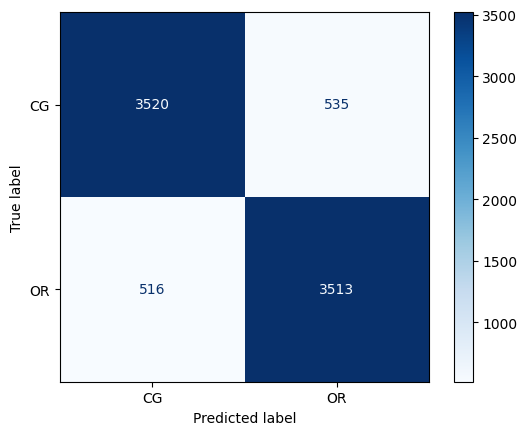

In [29]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Train the model on the combined features
lr_model.fit(X_train_combined, y_train)

# Make predictions on the combined test features
lr_pred = lr_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Classification Report:\n", classification_report(y_test, lr_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'OR'])
disp.plot(cmap='Blues')

# Optionally, print the confusion matrix values
print("Confusion Matrix:\n", cm)

Random Forest Accuracy: 0.8440
Random Forest Classification Report:
               precision    recall  f1-score   support

          CG       0.84      0.86      0.85      4055
          OR       0.85      0.83      0.84      4029

    accuracy                           0.84      8084
   macro avg       0.84      0.84      0.84      8084
weighted avg       0.84      0.84      0.84      8084

Confusion Matrix:
 [[3478  577]
 [ 684 3345]]


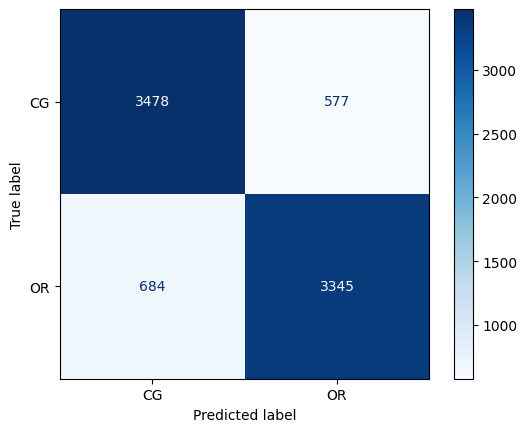

In [30]:
# Initialize the Random Forest model
rfc_model = RandomForestClassifier()

# Train the model
rfc_model.fit(X_train_combined, y_train)

# Make predictions
rfc_pred = rfc_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, rfc_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest Classification Report:\n", classification_report(y_test, rfc_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, rfc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'OR'])
disp.plot(cmap='Blues')

# Optionally, print the confusion matrix values
print("Confusion Matrix:\n", cm)

SVC Accuracy: 0.8850
SVC Classification Report:
               precision    recall  f1-score   support

          CG       0.89      0.88      0.89      4055
          OR       0.88      0.89      0.88      4029

    accuracy                           0.88      8084
   macro avg       0.88      0.88      0.88      8084
weighted avg       0.88      0.88      0.88      8084

Confusion Matrix:
 [[3582  473]
 [ 457 3572]]


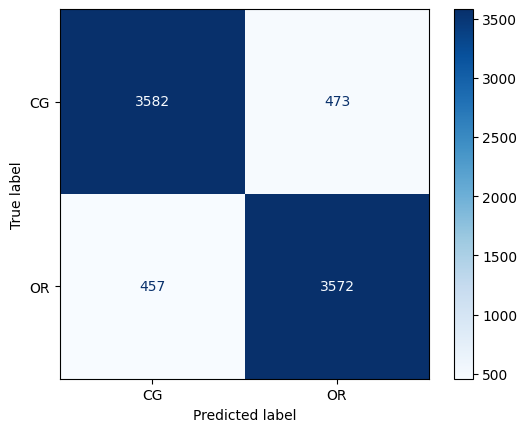

In [31]:
# Initialize the Support Vector Classifier (SVC) model
svc_model = SVC()

# Train the model
svc_model.fit(X_train_combined, y_train)

# Make predictions
svc_pred = svc_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, svc_pred)
print(f"SVC Accuracy: {accuracy:.4f}")
print(f"SVC Classification Report:\n", classification_report(y_test, svc_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'OR'])
disp.plot(cmap='Blues')

# Optionally, print the confusion matrix values
print("Confusion Matrix:\n", cm)

Minimum value in combined features: -1.0
Multinomial Naive Bayes Accuracy: 0.8362
Multinomial Naive Bayes Classification Report:
               precision    recall  f1-score   support

          CG       0.81      0.88      0.84      4055
          OR       0.86      0.80      0.83      4029

    accuracy                           0.84      8084
   macro avg       0.84      0.84      0.84      8084
weighted avg       0.84      0.84      0.84      8084

Confusion Matrix:
 [[3554  501]
 [ 823 3206]]


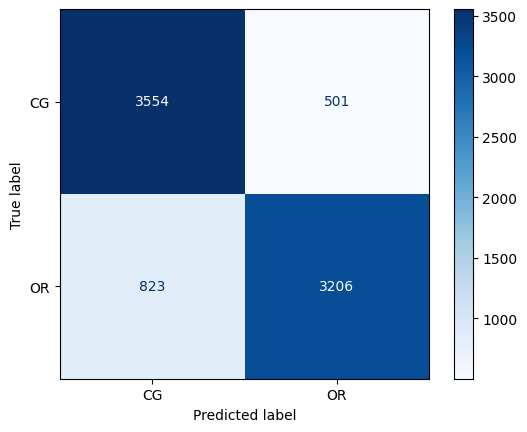

In [32]:
import numpy as np

# Check for negative values in the combined features
combined_dense = X_train_combined.toarray()
print("Minimum value in combined features:", np.min(combined_dense))

# If there are negative values, clip them to be non-negative
X_train[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']] = X_train[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']].clip(lower=0)

# Rebuild the combined features
X_train_combined = sp.hstack([X_train_text, X_train[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']].values])

# Initialize the Multinomial Naive Bayes model
mnb_model = MultinomialNB()

# Train the model
mnb_model.fit(X_train_combined, y_train)

# Make predictions
mnb_pred = mnb_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, mnb_pred)
print(f"Multinomial Naive Bayes Accuracy: {accuracy:.4f}")
print(f"Multinomial Naive Bayes Classification Report:\n", classification_report(y_test, mnb_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, mnb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'OR'])
disp.plot(cmap='Blues')

# Optionally, print the confusion matrix values
print("Confusion Matrix:\n", cm)

Decision Tree Accuracy: 0.7511
Decision Tree Classification Report:
               precision    recall  f1-score   support

          CG       0.76      0.74      0.75      4055
          OR       0.75      0.76      0.75      4029

    accuracy                           0.75      8084
   macro avg       0.75      0.75      0.75      8084
weighted avg       0.75      0.75      0.75      8084

Confusion Matrix:
 [[3014 1041]
 [ 971 3058]]


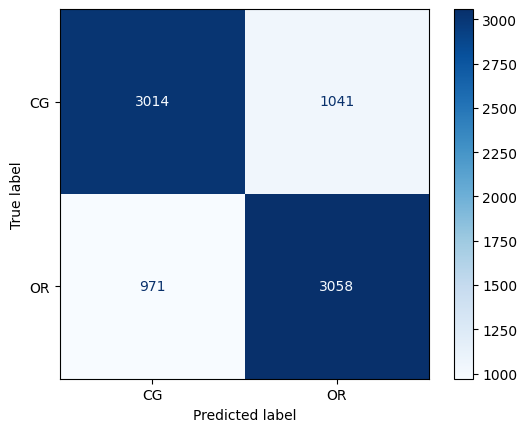

In [33]:
# Initialize the Decision Tree model
dtree_model = DecisionTreeClassifier()

# Train the model
dtree_model.fit(X_train_combined, y_train)

# Make predictions
dtree_pred = dtree_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, dtree_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print(f"Decision Tree Classification Report:\n", classification_report(y_test, dtree_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, dtree_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'OR'])
disp.plot(cmap='Blues')

# Optionally, print the confusion matrix values
print("Confusion Matrix:\n", cm)

KNN Accuracy: 0.6951
KNN Classification Report:
               precision    recall  f1-score   support

          CG       0.64      0.92      0.75      4055
          OR       0.85      0.47      0.61      4029

    accuracy                           0.70      8084
   macro avg       0.74      0.69      0.68      8084
weighted avg       0.74      0.70      0.68      8084

Confusion Matrix:
 [[3719  336]
 [2129 1900]]


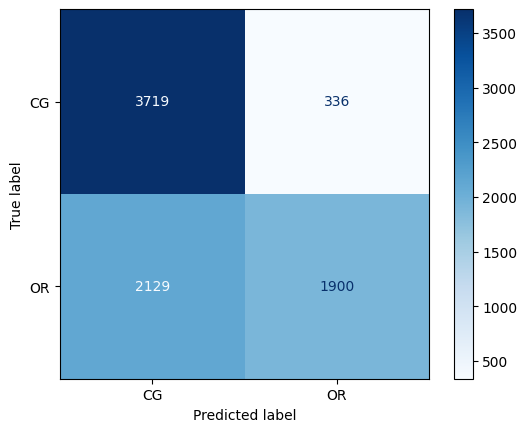

In [34]:
# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train_combined, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, knn_pred)
print(f"KNN Accuracy: {accuracy:.4f}")
print(f"KNN Classification Report:\n", classification_report(y_test, knn_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'OR'])
disp.plot(cmap='Blues')

# Optionally, print the confusion matrix values
print("Confusion Matrix:\n", cm)

In [35]:
from sklearn.metrics import accuracy_score
import numpy as np

# Print the accuracy of each model
print('Performance of various ML models:\n')

print('Logistic Regression Prediction Accuracy:', str(np.round(accuracy_score(y_test, lr_pred) * 100, 2)) + '%')
print('Random Forests Classifier Prediction Accuracy:', str(np.round(accuracy_score(y_test, rfc_pred) * 100, 2)) + '%')
print('Support Vector Machines Prediction Accuracy:', str(np.round(accuracy_score(y_test, svc_pred) * 100, 2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:', str(np.round(accuracy_score(y_test, mnb_pred) * 100, 2)) + '%')
print('Decision Tree Classifier Prediction Accuracy:', str(np.round(accuracy_score(y_test, dtree_pred) * 100, 2)) + '%')
print('K Nearest Neighbors Prediction Accuracy:', str(np.round(accuracy_score(y_test, knn_pred) * 100, 2)) + '%')

Performance of various ML models:

Logistic Regression Prediction Accuracy: 87.0%
Random Forests Classifier Prediction Accuracy: 84.4%
Support Vector Machines Prediction Accuracy: 88.5%
Multinomial Naive Bayes Prediction Accuracy: 83.62%
Decision Tree Classifier Prediction Accuracy: 75.11%
K Nearest Neighbors Prediction Accuracy: 69.51%


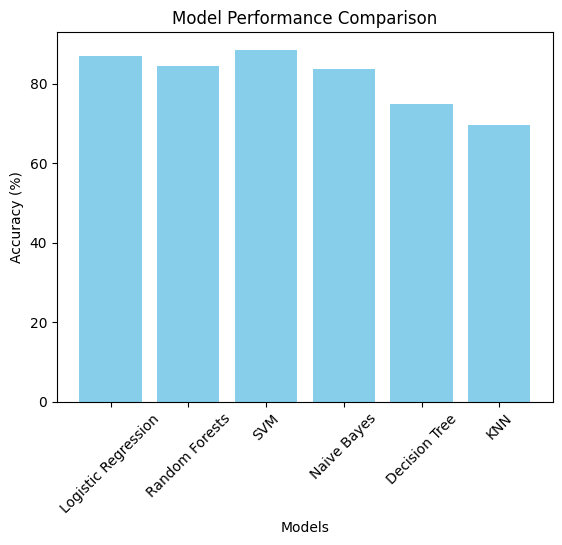

In [36]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forests', 'SVM', 'Naive Bayes', 'Decision Tree', 'KNN']
accuracies = [87.0, 84.45, 88.5, 83.62, 74.96, 69.51]

plt.bar(models, accuracies, color='skyblue')
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.show()

## Further improvements


Classification report for Logistic Regression at threshold 0.42:

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1006
           1       0.87      0.93      0.90       994

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000


Classification report for Random Forest at threshold 0.43:

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1006
           1       0.91      0.97      0.94       994

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000


Classification report for SVC at threshold 0.52:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1006
           1       0.91      0.94      0.93       994

   

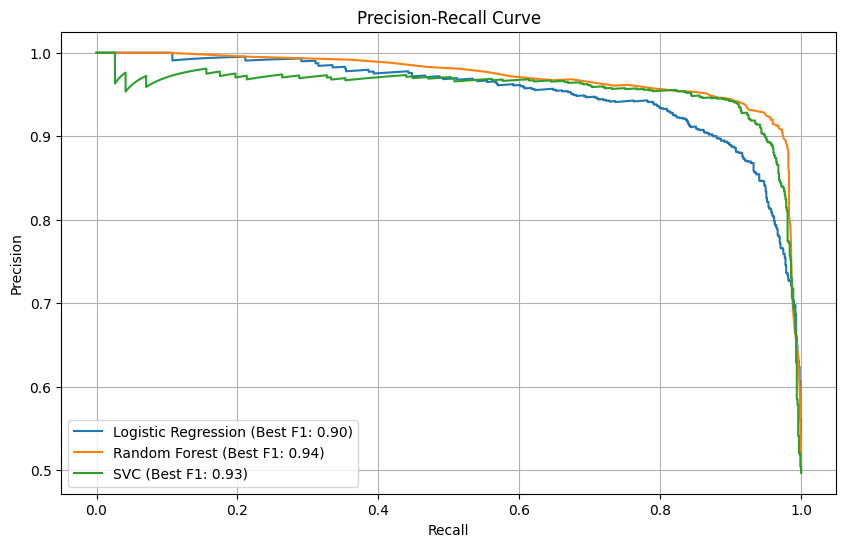

In [65]:
# Required imports
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Generate synthetic data for demonstration
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True),  # Set probability=True to get predicted probabilities
}

# Encode labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Convert categorical labels to binary labels

# Store results
results = {}

# Train models and evaluate decision thresholds
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
    # Calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_probs)
    
    # Calculate F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Find the best threshold based on F1 score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if best_index < len(thresholds) else 0.5
    results[model_name] = {
        'best_threshold': best_threshold,
        'best_f1_score': f1_scores[best_index],
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }
    
    # Print classification report at the best threshold
    y_pred_best = (y_probs >= best_threshold).astype(int)
    print(f"\nClassification report for {model_name} at threshold {best_threshold:.2f}:\n")
    print(classification_report(y_test_encoded, y_pred_best))

# Visualize Precision-Recall Curve for each model
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    plt.plot(result['recall'], result['precision'], label=f'{model_name} (Best F1: {result["best_f1_score"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [66]:
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

X_train_combined shape: (32336, 5006)
X_test_combined shape: (8084, 5006)


In [67]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import pandas as pd
import numpy as np

# Load your cleaned dataset
data = pd.read_csv('cleaned_fake_reviews.csv')  # Replace with your actual dataset path

# Check for NaN values in the 'processed_text' column
if data['processed_text'].isnull().any():
    print("Found NaN values in 'processed_text' column. Filling NaN values with empty strings.")
    data.loc[data['processed_text'].isnull(), 'processed_text'] = ''  # Replace NaN with empty strings

# Prepare features and labels
X = data['processed_text']
y = data['label'].apply(lambda x: 1 if x == 'OR' else 0)  # Convert categories to binary labels

# Step 1: Vectorization
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Step 2: Train the Random Forest model
model = RandomForestClassifier()
model.fit(X_vectorized, y)

# Step 3: Save the model and vectorizer
dump(model, 'random_forest_model.joblib')
dump(vectorizer, 'tfidf_vectorizer.joblib')

print("Model and vectorizer saved successfully.")

Found NaN values in 'processed_text' column. Filling NaN values with empty strings.
Model and vectorizer saved successfully.


In [68]:
from joblib import load

# Load the trained model and vectorizer
loaded_model = load('random_forest_model.joblib')
loaded_vectorizer = load('tfidf_vectorizer.joblib')

# New reviews to test
new_reviews = [
    "Great headphones! Sound quality is amazing, and they’re comfortable to wear for long periods.",  # [OR]
    "The product arrived on time and was exactly as described. I am very satisfied with my purchase!", # [OR]
    "This charger works perfectly and charges my phone fast without overheating.",  # [OR]
    "I recently bought this phone, and I’m impressed with the performance and battery life. The camera quality is fantastic, especially in low light. The phone feels sleek, and the display is bright and clear. It has a good balance of features for the price. Highly recommend to anyone who wants a solid mid-range smartphone.",  # [OR]
    "I am so thoroughly impressed beyond expectation with this product! It’s by far the best purchase ever. It works perfectly every single time and has exceeded all my expectations. I highly recommend this to anyone looking for something that guarantees results. This is truly an honest review—I’ve never been more satisfied with a product in my life. If you haven’t bought it yet, you’re really missing out on something amazing!",  # [CG]
    "I recently purchased this product, and I have to say, I'm truly impressed with the quality! The build is solid, the design is sleek, and it works as advertised. I've been using it daily for a couple of weeks now, and everything is performing flawlessly. The customer service was also excellent, as they answered all my queries promptly. I would highly recommend this to anyone looking for a reliable, budget-friendly option!",  # [CG]
    "This is pure magic! I can’t believe how amazing it is! My friends are all jealous of me!", # [CG]
    "Unbelievable! This is the best thing I’ve ever purchased! You need this in your life!",  # [CG]
    "The product I received was of good quality. I loved it!", # [OR]
    "The product I received was the best purchase I ever made!" # [CG]
]

# Transform the new reviews using the loaded vectorizer
new_X_vectorized = loaded_vectorizer.transform(new_reviews)

# Make predictions using the loaded model
predictions = loaded_model.predict(new_X_vectorized)

# Map predictions to labels
label_mapping = {0: 'CG', 1: 'OR'}  # Assuming 0 is CG (fake) and 1 is OR (real)

# Print the results
for review, prediction in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted label: {label_mapping[prediction]}\n")

Review: Great headphones! Sound quality is amazing, and they’re comfortable to wear for long periods.
Predicted label: OR

Review: The product arrived on time and was exactly as described. I am very satisfied with my purchase!
Predicted label: OR

Review: This charger works perfectly and charges my phone fast without overheating.
Predicted label: OR

Review: I recently bought this phone, and I’m impressed with the performance and battery life. The camera quality is fantastic, especially in low light. The phone feels sleek, and the display is bright and clear. It has a good balance of features for the price. Highly recommend to anyone who wants a solid mid-range smartphone.
Predicted label: CG

Review: I am so thoroughly impressed beyond expectation with this product! It’s by far the best purchase ever. It works perfectly every single time and has exceeded all my expectations. I highly recommend this to anyone looking for something that guarantees results. This is truly an honest review